# KTRLite Examples

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import matplotlib
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTRLite

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand
from orbit.utils.plot import get_orbit_style
plt.style.use(get_orbit_style())

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
print(orbit.__version__)
print(matplotlib.__version__)

1.0.16dev
3.3.4


## Data

In [4]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()

DATE_COL = 'date'
RESPONSE_COL = 'electricity'

df[RESPONSE_COL] = np.log(df[RESPONSE_COL])

print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [5]:
print(f'starts with {df[DATE_COL].min()}\nends with {df[DATE_COL].max()}\nshape: {df.shape}')

starts with 2000-01-01 00:00:00
ends with 2008-12-31 00:00:00
shape: (3288, 2)


### Train / Test Split

In [6]:
test_size=365

train_df=df[:-test_size]
test_df=df[-test_size:]

## KTRLite

In [7]:
ktrlite = KTRLite(                   
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    span_level=.05,
    span_coefficients=.5,
    estimator='stan-map',
    n_bootstrap_draws=1e4,
)

In [8]:
ktrlite.fit(train_df)

Initial log joint probability = -187221
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -3413.12      0.639618       10482.1           1           1       24   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       4885.43     0.0267908       6398.92      0.1115           1       47   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       5103.69     0.0136451       1214.27      0.4103     0.04103       69   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       5140.97     0.0506903       605.486           1           1       89   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5161.55     0.0248064       415.743      0.1803           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha   

In [9]:
predicted_df = ktrlite.predict(df=test_df, decompose=True)
predicted_df.head()

,date,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_7_5,seasonality_7,seasonality_7_95,seasonality_365.25_5,seasonality_365.25,seasonality_365.25_95
0,2008-01-02,9.95535,10.02393,10.09320,9.98559,9.98712,9.98860,0.02475,0.02475,0.02475,0.01206,0.01206,0.01206
1,2008-01-03,9.95726,10.02471,10.09289,9.98406,9.98712,9.99009,0.02676,0.02676,0.02676,0.01084,0.01084,0.01084
2,2008-01-04,9.96889,10.03841,10.10730,9.98252,9.98712,9.99158,0.04162,0.04162,0.04162,0.00967,0.00967,0.00967
3,2008-01-05,9.89609,9.96546,10.03429,9.98099,9.98712,9.99307,-0.03022,-0.03022,-0.03022,0.00857,0.00857,0.00857
4,2008-01-06,9.83759,9.90698,9.97650,9.97946,9.98712,9.99456,-0.08767,-0.08767,-0.08767,0.00754,0.00754,0.00754


In [10]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df['electricity'].values):.2%}"

'SMAPE: 0.53%'

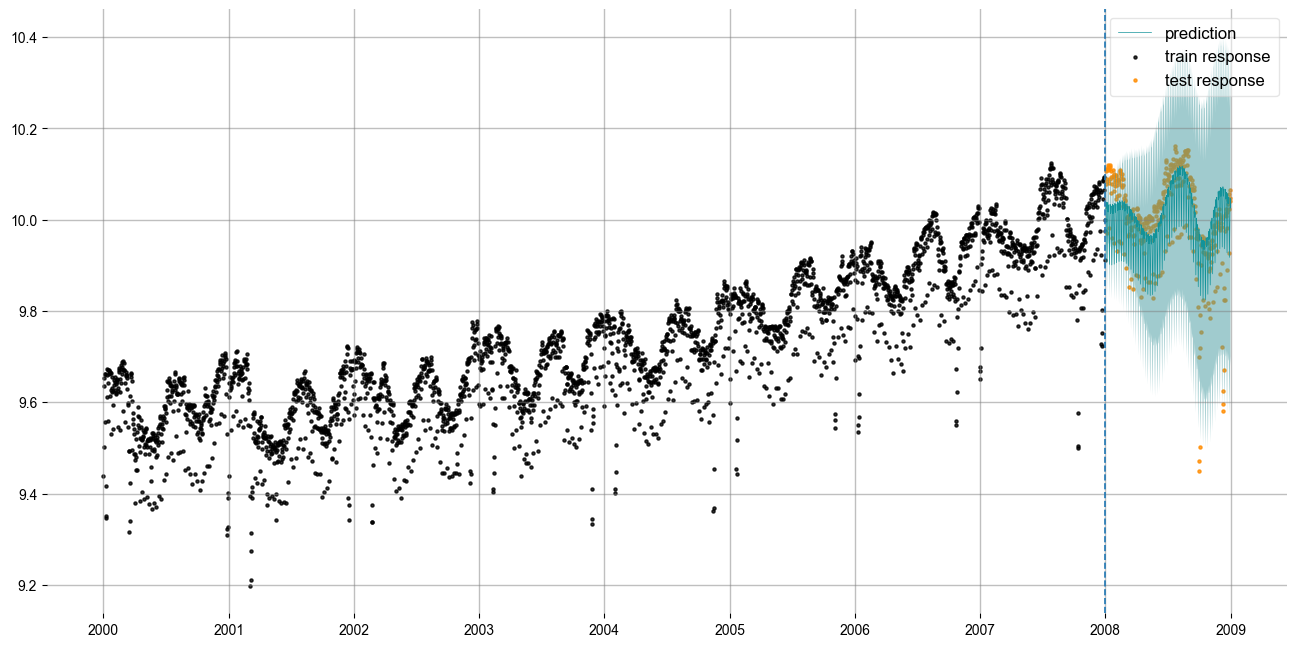

In [11]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df, 
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL, 
                        test_actual_df=test_df,
                        markersize=20, lw=.5)

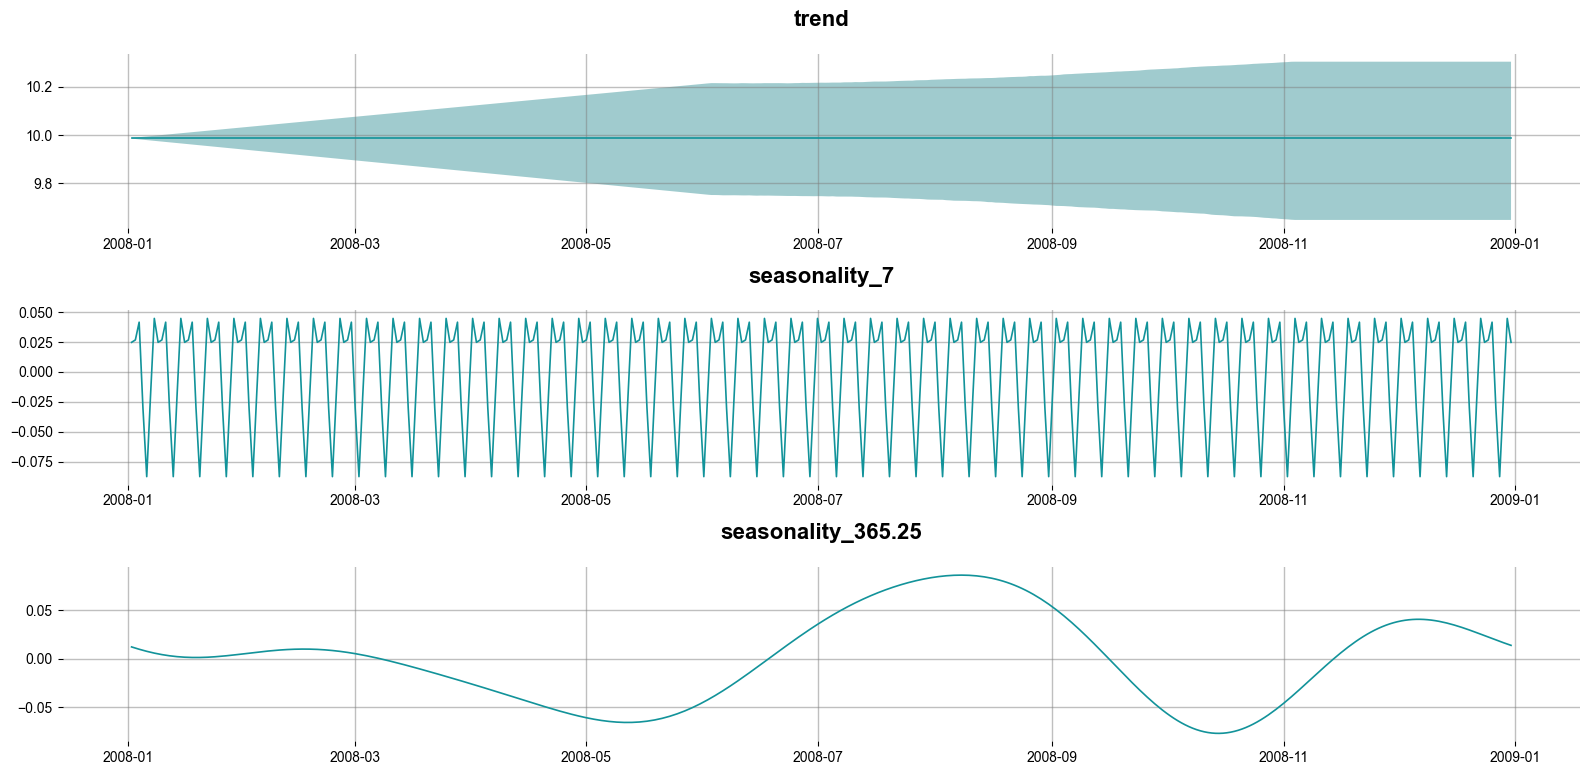

In [12]:
_ = plot_predicted_components(predicted_df=predicted_df,
                              date_col=DATE_COL, 
                              plot_components=['trend', 'seasonality_7', 'seasonality_365.25'])

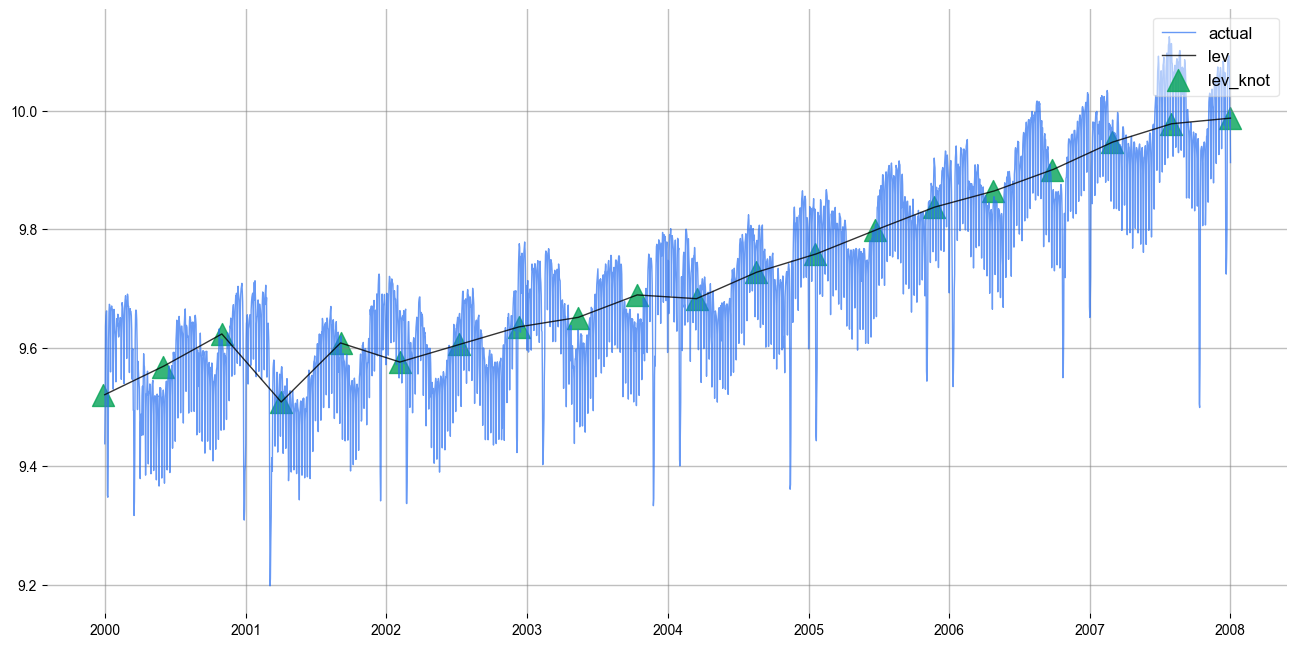

In [13]:
_ = ktrlite.plot_lev_knots()

In [14]:
lev_knots_df = ktrlite.get_level_knots()
lev_knots_df.head()

,date,lev_knot
0,1999-12-28,9.51911
1,2000-05-30,9.56743
2,2000-10-31,9.62286
3,2001-04-03,9.50803
4,2001-09-04,9.60772


# Stability Check

In [15]:
ktrlite1 = KTRLite(                   
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    span_level=.05,
    span_coefficients=.5,
    estimator='stan-map',
    seed=2020
)


ktrlite2 = KTRLite(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    span_level=.05,
    span_coefficients=.5,
    estimator='stan-map',
    seed=2021
)

ktrlite1.fit(df)
ktrlite2.fit(df)

Initial log joint probability = -230300
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       2022.41     0.0431795       12765.6      0.6279      0.6279       28   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       5007.64     0.0163082       2020.25      0.2595      0.2595       51   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       5386.86     0.0108695       567.961      0.9109      0.9109       73   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79        5442.7    0.00704644       714.096      0.9207      0.9207       94   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5456.88     0.0248819       215.799           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha   

In [16]:
np.allclose(
    ktrlite1.get_point_posteriors()['lev_knot'],
    ktrlite2.get_point_posteriors()['lev_knot'],
    rtol=1e-3,
)

True

In [17]:
from orbit.utils.simulation import make_trend, make_seasonality, make_regression
import pandas as pd
import numpy as np

n_obs = 365 * 3
seed = 2020
rw = make_trend(n_obs, rw_loc=0.02, rw_scale=0.1, seed=seed)
fs = make_seasonality(n_obs, seasonality=365, method='fourier', order=5, seed=seed)
coef = [0.2, 0.1, 0.3]
x, y, coef = make_regression(n_obs, coef, scale=2.0, seed=seed)

df = pd.DataFrame(np.concatenate([(rw + fs + y).reshape(-1, 1), x], axis=1), columns=['response'] + list('abc'))
df['date'] = pd.date_range(start='2016-01-01', periods=n_obs)
train_df = df[df['date'] < '2018-01-01']
test_df = df[df['date'] >= '2018-01-01']


In [18]:
ktrlite = KTRLite(
    response_col='response',
    date_col='date',
    seasonality=[365.25],
    seasonality_fs_order=[5],
    estimator='stan-map',
)

In [19]:
ktrlite.fit(train_df)

Initial log joint probability = -10858.4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -1051.02     0.0860378       45.4925           1           1       23   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       -1047.7   0.000785502       44.6022           1           1       49   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       -1047.5   0.000575157       42.9393           1           1       72   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68      -1047.28    0.00193666       41.6219   4.856e-05       0.001      116  LS failed, Hessian reset 
      79      -1047.23   4.90771e-05       42.0339      0.2995           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99      -1047.17   0.000142339    